In [ ]:
!pip install datasets scikit-learn matplotlib nltk

# Importing necessary libraries
import nltk
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, KFold
import matplotlib.pyplot as plt
import pandas as pd

# Downloading NLTK dependencies
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# DataLoader Class to load and transform data
class DataLoader:
    @staticmethod
    def load_conll2003():
        dataset = load_dataset("conll2003", trust_remote_code=True)
        return dataset['train'], dataset['test'], dataset['validation']

    @staticmethod
    def transform_to_dataset(dataset):
        X, y = [], []

        for item in dataset:
            tokens = item['tokens']
            pos_tags = item['pos_tags']
            ner_tags = item['ner_tags']

            for i in range(len(tokens)):
                X.append(FeatureExtractor.extract_features(tokens, pos_tags, i))
                y.append(1 if ner_tags[i] != 0 else 0)  # In the dataset 0 is for O while other values form 1 to 8 are for B/I

        return X, y

In [ ]:
# FeatureExtractor Class to extract features from tokens
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

class FeatureExtractor:
    @staticmethod
    def extract_features(tokens, pos_tags, i):
        word = tokens[i]
        postag = pos_tags[i]

        features = {
            'word': word,       # basic word features
            'word_lower': word.lower(),
            'is_title': word.istitle(),
            #'is_capitalized': word[0].upper() == word[0],
            'is_all_caps': word.upper() == word,
            'is_all_lower': word.lower() == word,
            'prefix-1': word[0],
            'prefix-2': word[:2],
            'suffix-1': word[-1],
            'suffix-2': word[-2:],
            'is_stopword': word.lower() in stop_words,
            'is_punctuation': word in punctuation,

            'is_first': i == 0,     # sentence position features
            'is_last': i == len(tokens) - 1,

            'prev_word': '' if i == 0 else tokens[i - 1],   # contextual features
            'prev_word_is_title': '' if i == 0 else tokens[i - 1].istitle(),
            'next_word': '' if i == len(tokens) - 1 else tokens[i + 1],
            'next_word_is_title': '' if i == len(tokens) - 1 else tokens[i + 1].istitle(),

            #'postag': postag,      # POS tags for context
            #'prev_postag': '' if i == 0 else pos_tags[i - 1],
            #'next_postag': '' if i == len(pos_tags) - 1 else pos_tags[i + 1],
        }

        # if i > 0:
        #     features['prev_bigram'] = tokens[i - 1] + ' ' + word
        # if i < len(tokens) - 1:
        #     features['next_bigram'] = word + ' ' + tokens[i + 1]
        # if i > 1:
        #     features['prev_trigram'] = tokens[i - 2] + ' ' + tokens[i - 1] + ' ' + word
        # if i < len(tokens) - 2:
        #     features['next_trigram'] = word + ' ' + tokens[i + 1] + ' ' + tokens[i + 2]

        return features

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ModelTrainer Class for training and cross-validation
class ModelTrainer:
    def __init__(self, X):
        self.vectorizer = DictVectorizer(sparse=True)
        self.model = LinearSVC(max_iter=10000)
        self.vectorizer.fit(X)

    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X)
        self.model.fit(X, y)

    def cross_validate(self, X, y, folds=5):
        X = self.vectorizer.fit_transform(X)
        kf = KFold(n_splits=folds, shuffle=True, random_state=42)
        y_pred = cross_val_predict(self.model, X, y, cv=kf)

        print("Classification Report (5-Fold Cross-Validation):")
        print(classification_report(y, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "B/I"])
        disp.plot(cmap="Greys")
        plt.title("Confusion Matrix")
        plt.show()

In [ ]:
# Predictor Class to predict NER for a single sentence
class Predictor:
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def predict_single_sentence(self, sentence):
        tokens = nltk.word_tokenize(sentence)
        pos_tags = [nltk.pos_tag([word])[0][1] for word in tokens]
        sent = {'tokens': tokens, 'pos_tags': pos_tags}

        features = [FeatureExtractor.extract_features(sent['tokens'], sent['pos_tags'], i) for i in range(len(tokens))]
        X_sent = self.vectorizer.transform(features)

        y_sent_pred = self.model.predict(X_sent)
        return list(zip(tokens, ["B/I" if tag == 1 else "O" for tag in y_sent_pred]))

In [ ]:
# Load and transform data
train_data, test_data, _ = DataLoader.load_conll2003()
X_train, y_train = DataLoader.transform_to_dataset(train_data)
X_test, y_test = DataLoader.transform_to_dataset(test_data)

In [ ]:
# Train and evaluate the model with cross-validation
trainer = ModelTrainer(X_train + X_test)
#trainer.cross_validate(X_train, y_train, folds=5)

In [ ]:
trainer.fit(X_train, y_train)
predictor = Predictor(trainer.model, trainer.vectorizer)

In [ ]:
s = "Washington DC is the capital of the United States Of America."
# s = "Bank of Japan"
predicted_nei = predictor.predict_single_sentence(s)

for word, tag in predicted_nei:
    print(f'{word}: {tag}')

Washington: B/I
DC: B/I
is: O
the: O
capital: O
of: O
the: O
United: B/I
States: B/I
Of: O
America: B/I
.: O


In [ ]:
s = "bank of japan"
predicted_nei = predictor.predict_single_sentence(s)

for word, tag in predicted_nei:
    print(f'{word}: {tag}')

bank: O
of: O
japan: O


In [ ]:
import pickle

# Save the ModelTrainer instance
with open("svm_model.pkl", "wb") as f:
    pickle.dump(trainer, f)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def eval(X, y):
    X = trainer.vectorizer.transform(X)
    y_pred = [trainer.model.predict(i) for i in X]

    print("Classification Report:")
    print(classification_report(y, y_pred, target_names=['O', 'B/I']))
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "B/I"])
    disp.plot(cmap="Greys")
    plt.title("Confusion Matrix")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     38323
         B/I       0.94      0.97      0.95      8112

    accuracy                           0.98     46435
   macro avg       0.97      0.98      0.97     46435
weighted avg       0.98      0.98      0.98     46435

Precision: 0.9834
Recall: 0.9831
F1 Score: 0.9832



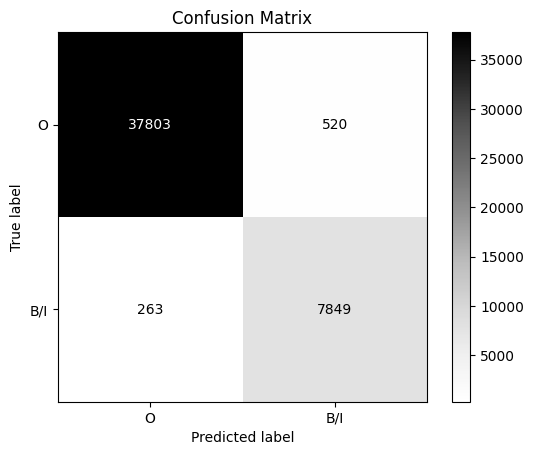

In [ ]:
eval(X_test, y_test)

## ChatGPT Comparison

In [ ]:
for i in range(11,100+11):
    print('(', i-10, ') ', test_data[i]['tokens'])
    if i %10 == 0:
        print()

( 1 )  ['It', 'was', 'the', 'second', 'costly', 'blunder', 'by', 'Syria', 'in', 'four', 'minutes', '.']
( 2 )  ['Defender', 'Hassan', 'Abbas', 'rose', 'to', 'intercept', 'a', 'long', 'ball', 'into', 'the', 'area', 'in', 'the', '84th', 'minute', 'but', 'only', 'managed', 'to', 'divert', 'it', 'into', 'the', 'top', 'corner', 'of', 'Bitar', "'s", 'goal', '.']
( 3 )  ['Nader', 'Jokhadar', 'had', 'given', 'Syria', 'the', 'lead', 'with', 'a', 'well-struck', 'header', 'in', 'the', 'seventh', 'minute', '.']
( 4 )  ['Japan', 'then', 'laid', 'siege', 'to', 'the', 'Syrian', 'penalty', 'area', 'for', 'most', 'of', 'the', 'game', 'but', 'rarely', 'breached', 'the', 'Syrian', 'defence', '.']
( 5 )  ['Bitar', 'pulled', 'off', 'fine', 'saves', 'whenever', 'they', 'did', '.']
( 6 )  ['Japan', 'coach', 'Shu', 'Kamo', 'said', ':', "'", "'", 'The', 'Syrian', 'own', 'goal', 'proved', 'lucky', 'for', 'us', '.']
( 7 )  ['The', 'Syrians', 'scored', 'early', 'and', 'then', 'played', 'defensively', 'and', 'adop

In [ ]:
chatgpt_answers = [
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],    # 4
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0],
    [1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],  # 20
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0],
    [1, 1],
    [1, 0, 1, 1],
    [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], # 16
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,0, 1, 0, 0, 1, 0, 0,0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
      [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
      [1, 0, 1, 1, 1, 1],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0],
      [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
      [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
]
for i in range(11,11+30):
    if len(test_data[i]['ner_tags']) != len(chatgpt_answers[i-11]):
        print(i-10, len(test_data[i]['ner_tags']), len(chatgpt_answers[i-11]))
        print(test_data[i]['ner_tags'])
        print(chatgpt_answers[i-11])

In [ ]:
answers_51_60 = [
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0]
  ]

In [ ]:
answers_41_50 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0],
    [0, 1, 1, 0, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0, 0]
]

In [ ]:
answers_31_40 = [
    [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [],
    [],
    [1, 1, 0, 1, 1, 1],
    [1, 1, 0, 1],
    [1, 0, 0, 0, 1]
]

In [ ]:
chatgpt_answers += answers_31_40
chatgpt_answers += answers_41_50
chatgpt_answers += answers_51_60
for i in range(11,11+60):
    if len(test_data[i]['ner_tags']) != len(chatgpt_answers[i-11]):
        print(i-10, len(test_data[i]['ner_tags']), len(chatgpt_answers[i-11]))
        print(test_data[i]['ner_tags'])
        print(chatgpt_answers[i-11])

36 71 0
[5, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0]
[]
37 72 0
[5, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0]
[]


In [ ]:
def perf(y, y_pred):
    print("Classification Report:")
    print(classification_report(y, y_pred, target_names=['O', 'B/I']))
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print()

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["O", "B/I"])
    disp.plot(cmap="Greys")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
for i in range(2,3):
    if i == 46 or i == 47:
        continue
    correct_ner = test_data[i]['ner_tags']
    correct_ner = [int(tag != 0) for tag in correct_ner]
    sent = ' '.join(test_data[i]['tokens'])
    svm_model = predictor.predict_single_sentence(sent)
    svm_model = [int(tag != 'O') for _, tag in svm_model]
    correct_ner_tag += correct_ner
    svm_model_tag += svm_model
    chatgpt_tag += chatgpt_answers[i-11]
    print(sent)
    print("CHATGPT: ", chatgpt_answers[i-11])
    print("SVM: ", svm_model)
    print("Correct: ", correct_ner)

AL-AIN , United Arab Emirates 1996-12-06
CHATGPT:  [0, 1, 1, 0, 1, 0, 0]
SVM:  [1, 0, 1, 1, 1, 0]
Correct:  [1, 0, 1, 1, 1, 0]


In [ ]:
correct_ner_tag = []
svm_model_tag = []
chatgpt_tag = []
for i in range(11, 11+42):
    if i == 46 or i == 47:
        continue
    correct_ner = test_data[i]['ner_tags']
    correct_ner = [int(tag != 0) for tag in correct_ner]
    sent = ' '.join(test_data[i]['tokens'])
    svm_model = predictor.predict_single_sentence(sent)
    svm_model = [int(tag != 'O') for _, tag in svm_model]
    correct_ner_tag += correct_ner
    svm_model_tag += svm_model
    chatgpt_tag += chatgpt_answers[i-11]

Classification Report:
              precision    recall  f1-score   support

           O       0.99      1.00      1.00       576
         B/I       0.99      0.98      0.98       142

    accuracy                           0.99       718
   macro avg       0.99      0.99      0.99       718
weighted avg       0.99      0.99      0.99       718

Precision: 0.9930
Recall: 0.9930
F1 Score: 0.9930



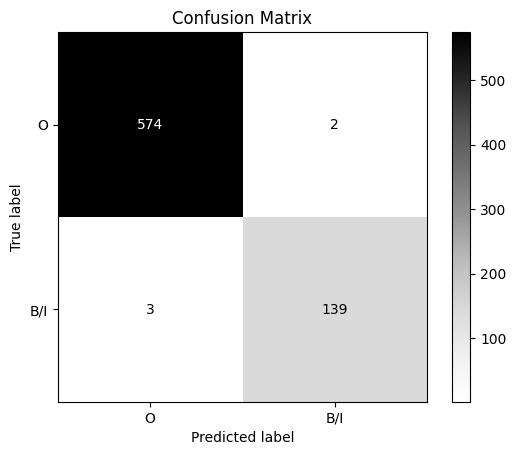

In [ ]:
perf(correct_ner_tag, svm_model_tag)

Classification Report:
              precision    recall  f1-score   support

           O       0.98      0.89      0.94       576
         B/I       0.68      0.94      0.79       142

    accuracy                           0.90       718
   macro avg       0.83      0.91      0.86       718
weighted avg       0.92      0.90      0.91       718

Precision: 0.9233
Recall: 0.9011
F1 Score: 0.9065



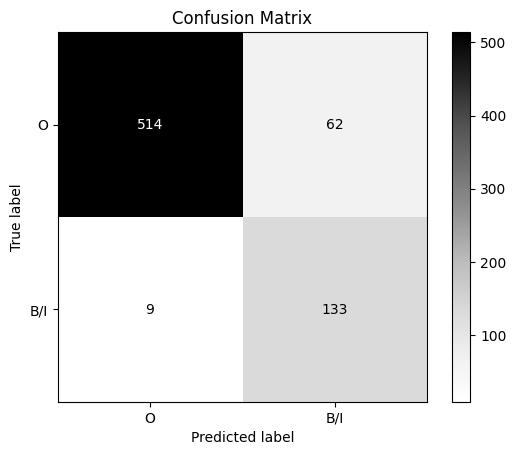

In [ ]:
perf(correct_ner_tag, chatgpt_tag)

In [ ]:
chatgpt_answer_train = [
    [1, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 1],
    [1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0],
    [0, 1, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1,0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0],
    [1,0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

In [ ]:
sentences = [
    ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
    ['Peter', 'Blackburn'],
    ['BRUSSELS', '1996-08-22'],
    ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'],
    ['He', 'said', 'further', 'scientific', 'study', 'was', 'required', 'and', 'if', 'it', 'was', 'found', 'that', 'action', 'was', 'needed', 'it', 'should', 'be', 'taken', 'by', 'the', 'European', 'Union', '.'],
    ['He', 'said', 'a', 'proposal', 'last', 'month', 'by', 'EU', 'Farm', 'Commissioner', 'Franz', 'Fischler', 'to', 'ban', 'sheep', 'brains', ',', 'spleens', 'and', 'spinal', 'cords', 'from', 'the', 'human', 'and', 'animal', 'food', 'chains', 'was', 'a', 'highly', 'specific', 'and', 'precautionary', 'move', 'to', 'protect', 'human', 'health', '.'],
    ['Fischler', 'proposed', 'EU-wide', 'measures', 'after', 'reports', 'from', 'Britain', 'and', 'France', 'that', 'under', 'laboratory', 'conditions', 'sheep', 'could', 'contract', 'Bovine', 'Spongiform', 'Encephalopathy', '(', 'BSE', ')', '--', 'mad', 'cow', 'disease', '.'],
    ['But', 'Fischler', 'agreed', 'to', 'review', 'his', 'proposal', 'after', 'the', 'EU', "'s", 'standing', 'veterinary', 'committee', ',', 'mational', 'animal', 'health', 'officials', ',', 'questioned', 'if', 'such', 'action', 'was', 'justified', 'as', 'there', 'was', 'only', 'a', 'slight', 'risk', 'to', 'human', 'health', '.'],
    ['Spanish', 'Farm', 'Minister', 'Loyola', 'de', 'Palacio', 'had', 'earlier', 'accused', 'Fischler', 'at', 'an', 'EU', 'farm', 'ministers', "'", 'meeting', 'of', 'causing', 'unjustified', 'alarm', 'through', '"', 'dangerous', 'generalisation', '.', '"'],
    ['.'],
    ['Only', 'France', 'and', 'Britain', 'backed', 'Fischler', "'s", 'proposal', '.'],
    ['The', 'EU', "'s", 'scientific', 'veterinary', 'and', 'multidisciplinary', 'committees', 'are', 'due', 'to', 're-examine', 'the', 'issue', 'early', 'next', 'month', 'and', 'make', 'recommendations', 'to', 'the', 'senior', 'veterinary', 'officials', '.'],
    ['Sheep', 'have', 'long', 'been', 'known', 'to', 'contract', 'scrapie', ',', 'a', 'brain-wasting', 'disease', 'similar', 'to', 'BSE', 'which', 'is', 'believed', 'to', 'have', 'been', 'transferred', 'to', 'cattle', 'through', 'feed', 'containing', 'animal', 'waste', '.'],
    ['Germany', 'imported', '47,600', 'sheep', 'from', 'Britain', 'last', 'year', ',', 'nearly', 'half', 'of', 'total', 'imports', '.'],
    ['It', 'brought', 'in', '4,275', 'tonnes', 'of', 'British', 'mutton', ',', 'some', '10', 'percent', 'of', 'overall', 'imports', '.'],
    ['Rare', 'Hendrix', 'song', 'draft', 'sells', 'for', 'almost', '$', '17,000', '.'],
    ['LONDON', '1996-08-22'],
    ['A', 'rare', 'early', 'handwritten', 'draft', 'of', 'a', 'song', 'by', 'U.S.', 'guitar', 'legend', 'Jimi', 'Hendrix', 'was', 'sold', 'for', 'almost', '$', '17,000', 'on', 'Thursday', 'at', 'an', 'auction', 'of', 'some', 'of', 'the', 'late', 'musician', "'s", 'favourite', 'possessions', '.'],
    ['A', 'Florida', 'restaurant', 'paid', '10,925', 'pounds', '(', '$', '16,935', ')', 'for', 'the', 'draft', 'of', '"', 'Ai', "n't", 'no', 'telling', '"', ',', 'which', 'Hendrix', 'penned', 'on', 'a', 'piece', 'of', 'London', 'hotel', 'stationery', 'in', 'late', '1966', '.'],
    ['At', 'the', 'end', 'of', 'a', 'January', '1967', 'concert', 'in', 'the', 'English', 'city', 'of', 'Nottingham', 'he', 'threw', 'the', 'sheet', 'of', 'paper', 'into', 'the', 'audience', ',', 'where', 'it', 'was', 'retrieved', 'by', 'a', 'fan', '.'],
    ['The', 'guitarist', 'died', 'of', 'a', 'drugs', 'overdose', 'in', '1970', 'aged', '27', '.'],
    ['China', 'says', 'Taiwan', 'spoils', 'atmosphere', 'for', 'talks', '.'],
    ['BEIJING', '1996-08-22'],
    ['China', 'on', 'Thursday', 'accused', 'Taipei', 'of', 'spoiling', 'the', 'atmosphere', 'for', 'a', 'resumption', 'of', 'talks', 'across', 'the', 'Taiwan', 'Strait', 'with', 'a', 'visit', 'to', 'Ukraine', 'by', 'Taiwanese', 'Vice', 'President', 'Lien', 'Chan', 'this', 'week', 'that', 'infuriated', 'Beijing', '.'],
    ['"', 'Now', 'is', 'the', 'time', 'for', 'the', 'two', 'sides', 'to', 'engage', 'in', 'political', 'talks', '...'],
    ['The', 'foreign', 'ministry', "'s", 'Shen', 'told', 'Reuters', 'Television', 'in', 'an', 'interview', 'he', 'had', 'read', 'reports', 'of', 'Tang', "'s", 'comments', 'but', 'gave', 'no', 'details', 'of', 'why', 'the', 'negotiator', 'had', 'considered', 'the', 'time', 'right', 'for', 'talks', 'with', 'Taiwan', ',', 'which', 'Beijing', 'considers', 'a', 'renegade', 'province', '.'],
    ['China', 'says', 'time', 'right', 'for', 'Taiwan', 'talks', '.'],
    ['BEIJING', '1996-08-22'],
    ['China', 'has', 'said', 'it', 'was', 'time', 'for', 'political', 'talks', 'with', 'Taiwan', 'and', 'that', 'the', 'rival', 'island', 'should', 'take', 'practical', 'steps', 'towards', 'that', 'goal', '.'],
    ['German', 'July', 'car', 'registrations', 'up', '14.2', 'pct', 'yr', '/', 'yr', '.']
]

In [ ]:
dataset_answer = [
    [1, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 1],
    [1, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0],
    [0, 1, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0],
    [1,0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0],
    [1,0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

In [ ]:
for i in range(len(sentences)):
    svm_model = predictor.predict_single_sentence(' '.join(sentences[i]))
    svm_model = [int(tag != 'O') for _, tag in svm_model]
    svm_model_tag += svm_model
    chatgpt_tag += chatgpt_answer_train[i]
    correct_ner_tag += dataset_answer[i]

Classification Report:
              precision    recall  f1-score   support

           O       0.98      0.93      0.96      1071
         B/I       0.74      0.92      0.82       219

    accuracy                           0.93      1290
   macro avg       0.86      0.93      0.89      1290
weighted avg       0.94      0.93      0.93      1290

Precision: 0.9405
Recall: 0.9302
F1 Score: 0.9332



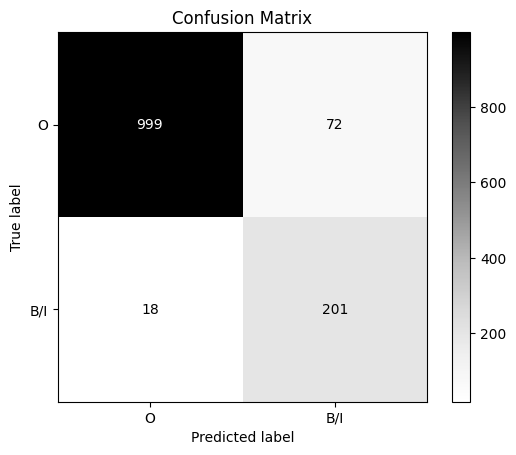

In [ ]:
perf(correct_ner_tag, chatgpt_tag)

Classification Report:
              precision    recall  f1-score   support

           O       1.00      1.00      1.00      1071
         B/I       0.99      0.98      0.99       219

    accuracy                           1.00      1290
   macro avg       0.99      0.99      0.99      1290
weighted avg       1.00      1.00      1.00      1290

Precision: 0.9953
Recall: 0.9953
F1 Score: 0.9953



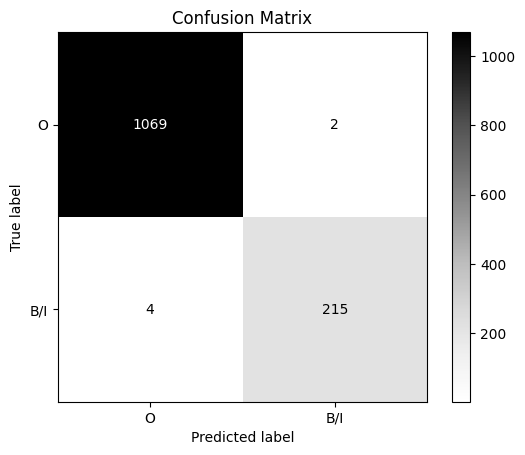

In [ ]:
perf(correct_ner_tag, svm_model_tag)